In [38]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb

from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data
from codelib.statistics import calculate_cornish_fisher_percentile

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 3

In this week we will look at a few exercises involving univariate and multivariate statistics. 

## Problem 1: The Student's t distribution 

We assume that the random variable $T$ follows a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution): 

$$
T = \frac{Z}{\sqrt{\frac{\nu}{V}}} \sim t(\nu)
$$

where $Z\sim N(0,1)$ and $ V \sim \chi^2(\nu)$ are independent, and $\nu$ is the degrees of freedom. The distribution can be represented by the density (pdf)

$$
f_T(t) = \textstyle\frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{t^2}{\nu} \right)^{-\frac{\nu+1}{2}}\!
$$

__Question 1__

Plot the pdfs for the cases $\nu = 2, 10, 50$. Plot the pdf of a standard normal for comparison.

__Question 2__

The t-distribution is used for small sample hypothesis testing when it is reasonable to assume that the random sample $X_1, ..., X_n$ is iid from the distribution $N(\mu, \sigma^2)$. 

Define the sample mean 

$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i
$$

and the sample variance

$$
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2
$$

The "Z-score" (under the normallity assumption)

$$
\frac{\bar{X} - \mu}{\sqrt{\frac{S^2}{n}}} \sim t(n-1)
$$

such that we can construct confidence intervals for $\mu$, the only unknown parameter. 

Simulate 10,000 samples of size $n=10$ when $X_i \sim N(5, 4)$. For each sample, calculate the sample mean, variance and the "Z-score". Plot a histogram of the Z-scores and compare with the pdf of the true distribution. Plot the pdf of a standard normal distribution for comparison. 

__Question 3__

Repeat question 2 with $n = 25$. 

__Question 4__

We want to calculate the expected value of 

$$
g(T) = e^{5 + 10\cdot T}
$$

where $T \sim t(5)$. Calculate this expectation using `scipy.t.expect`. 

__Question 5__

We want to calculate the expected value of 

$$
h(T) = 5 \cdot x^2
$$

where $T \sim t(5)$. Calculate this expectation using `scipy.t.expect`. 


### Solution

__Question 1__

When $\nu \to \infty$ then the t-distribution converges to a standard normal distribution. For small $\nu$ the distribution is more leptokurtic (fatter tails). 

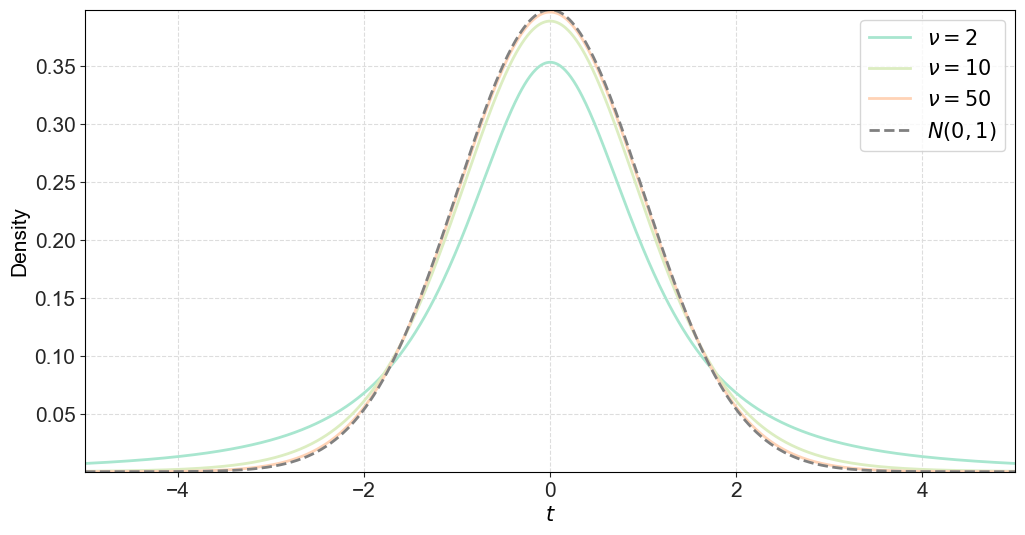

In [39]:
t_values = np.linspace(-5, 5, 1000)
pdf_nu2_values = stats.t.pdf(t_values, 2)
pdf_nu10_values = stats.t.pdf(t_values, 10)
pdf_nu50_values = stats.t.pdf(t_values, 50)
pdf_norm_values = stats.norm.pdf(t_values)


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(t_values, pdf_nu2_values, label="$\\nu =2$")
ax.plot(t_values, pdf_nu10_values, label="$\\nu =10$")
ax.plot(t_values, pdf_nu50_values, label="$\\nu =50$")
ax.plot(t_values, pdf_norm_values, label="$N(0,1)$", linestyle="--", color="gray")

ax.set_ylabel('Density')
ax.set_xlabel('$t$')
ax.legend();

__Question 2__

It seems that the simulated distribution matches the true! Simulations may help get a understanding of the distributional properties of estimators and test statistics. 

There is an evident difference between the simulated distribution (and the true t-distribution) and the standard normal distribution indicating that we cannot use the CLT to perform hypothesis testing. 

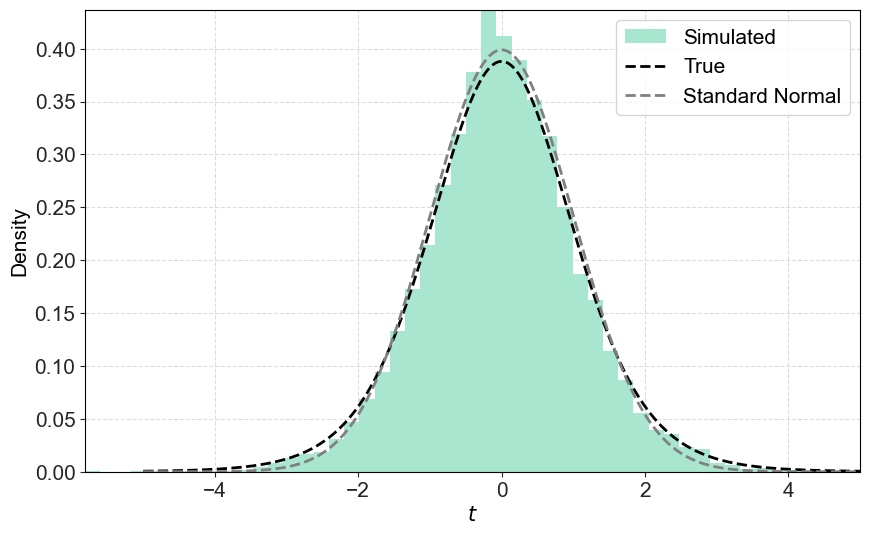

In [40]:
# set values
num_sim = 10000
sample_size = 10
mu = 5
sigma = 2

# simulate data
random_draws = np.random.normal(mu, sigma, size=(num_sim, sample_size))
sample_means = np.mean(random_draws, axis=1)
sample_var = np.var(random_draws, axis=1, ddof=1)
sample_z_scores = (sample_means - mu)/np.sqrt(sample_var/(sample_size - 1))

t_values = np.linspace(-5, 5, 1000)
# t-dist
pdf_values = stats.t.pdf(t_values, sample_size - 1)
# normal 
pdf_normal_values = stats.norm.pdf(t_values)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(sample_z_scores, bins=50, density=True, label="Simulated")
ax.plot(t_values, pdf_values, color="black", linestyle="--", label="True")
ax.plot(t_values, pdf_normal_values, color="gray", linestyle='--', label="Standard Normal")

ax.set_ylabel('Density')
ax.set_xlabel('$t$')
ax.legend();

__Question 3__

Now the distribution of the test statistics is much closer to the standard normal, which can be used as the asymptotic distribution of the test statistics (even for non-normal data). 

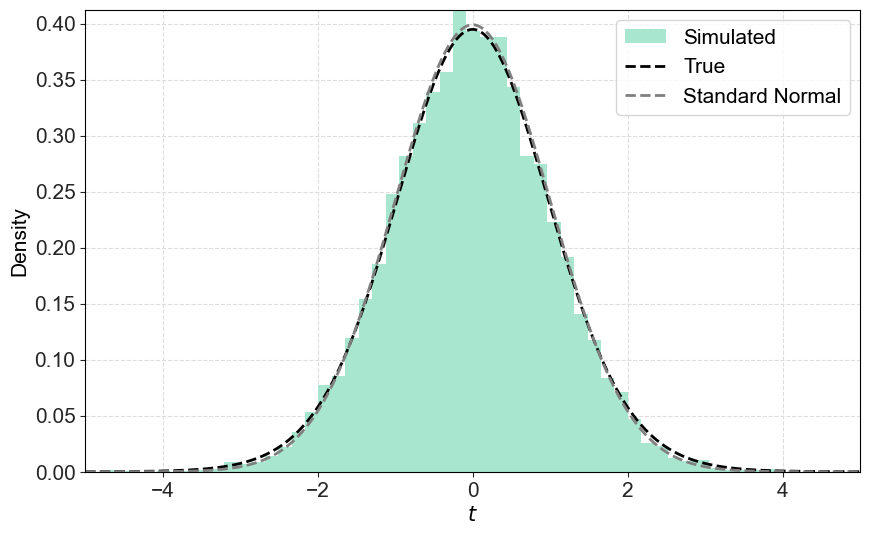

In [41]:
# set values
num_sim = 10000
sample_size = 25
mu = 5
sigma = 2

# simulate data
random_draws = np.random.normal(mu, sigma, size=(num_sim, sample_size))
sample_means = np.mean(random_draws, axis=1)
sample_var = np.var(random_draws, axis=1, ddof=1)
sample_z_scores = (sample_means - mu)/np.sqrt(sample_var/(sample_size - 1))

t_values = np.linspace(-5, 5, 1000)
# t-dist
pdf_values = stats.t.pdf(t_values, sample_size - 1)
# normal 
pdf_normal_values = stats.norm.pdf(t_values)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(sample_z_scores, bins=50, density=True, label="Simulated")
ax.plot(t_values, pdf_values, color="black", linestyle="--", label="True")
ax.plot(t_values, pdf_normal_values, color="gray", linestyle='--', label="Standard Normal")

ax.set_ylabel('Density')
ax.set_xlabel('$t$')
ax.legend();

__Question 4__

The expecation is not defined, so `inf` is returned.

In [42]:
"""
Define the function g(t)
"""

def g(t): 
    
    return np.exp(5.0 + 10.0 * t)



"""
Use stats.t.expect
"""

stats.t.expect(g, args=(5,))

C:\Users\johan\AppData\Local\Temp\ipykernel_32892\1868809380.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(5.0 + 10.0 * t)
C:\Users\johan\anaconda3\envs\fin_econ_2023\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2914: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dub = integrate.quad(fun, d, ub, **kwds)[0]


nan

__Question 5__

The expected value is defined and we can use the function to calculate the expected value. 

In [43]:
"""
Define the function h(t)
"""

def h(t): 
    
    return 5 * t**2

"""
Use stats.t.expect
"""

stats.t.expect(h, args=(5,))

8.333333333333332

## Problem 2: The empirical distribution function

In this exercise, we will have a look at the [empirical distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function). Remember that if we let $X_1, ..., X_n$ be a sequence iid random variables with cdf $F_X(x)$, then the empirical distribtion function is defined as 

$$
F_n(x) = \frac{1}{n}\sum_{i=1}^n I(X_i \leq x)
$$

__Question 1__

Simulate a random sample from a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) with $n=25$, $n=100$, $n=1000$, and $n=5000$. Assume $x_0=0$ and $\gamma=1$ in the wikipedia formulation, i.e. simply use the default in `SciPy`. Plot the Empirical distribution function for each case. Add the true CDF to the plot. 


__Question 2__

The [Dvoretzky–Kiefer–Wolfowitz inequality](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) states that the interval that contains the true CDF, $F(x)$, with probability $1-\alpha$ is specified as 

$$
F_n(x) - \epsilon \leq F(x) \leq F_n(x) + \epsilon
$$

with 

$$
\epsilon = \sqrt{\frac{\ln \frac{2}{\alpha}}{2n}}
$$

Implement this confidence interval for $\alpha=0.05$ and add them to the plots.

### Solution 

__Question 1__


In [77]:
# generate random variates from the cauchy distribution 
random_data = stats.cauchy.rvs(size=5000)

In [82]:
"""
Define simple function calculating the EDF

Note: It would be possible to use "statsmodels.distributions.empirical_distribution.ECDF"

See https://www.statsmodels.org/dev/generated/statsmodels.distributions.empirical_distribution.ECDF.html 
"""


def calculate_edf(x: Union[float, np.ndarray], data: np.ndarray) -> Union[float, np.ndarray]: 
    
    """
    Calculates the empirical distribution function 
    
    Parameters
    ----------
    x: 
        Values at which to evaluate the EDF
    data: 
        Data used to calculate the EDF
    
    Returns
    Union[float, np.ndarray]
    
    """
    
    n = len(data)
    sorted_data = data.copy()
    sorted_data.sort()
    probs = np.linspace(0.0, 1.0, n + 1)
    idx = np.searchsorted(sorted_data, x, side='right')
    
    return probs[idx]

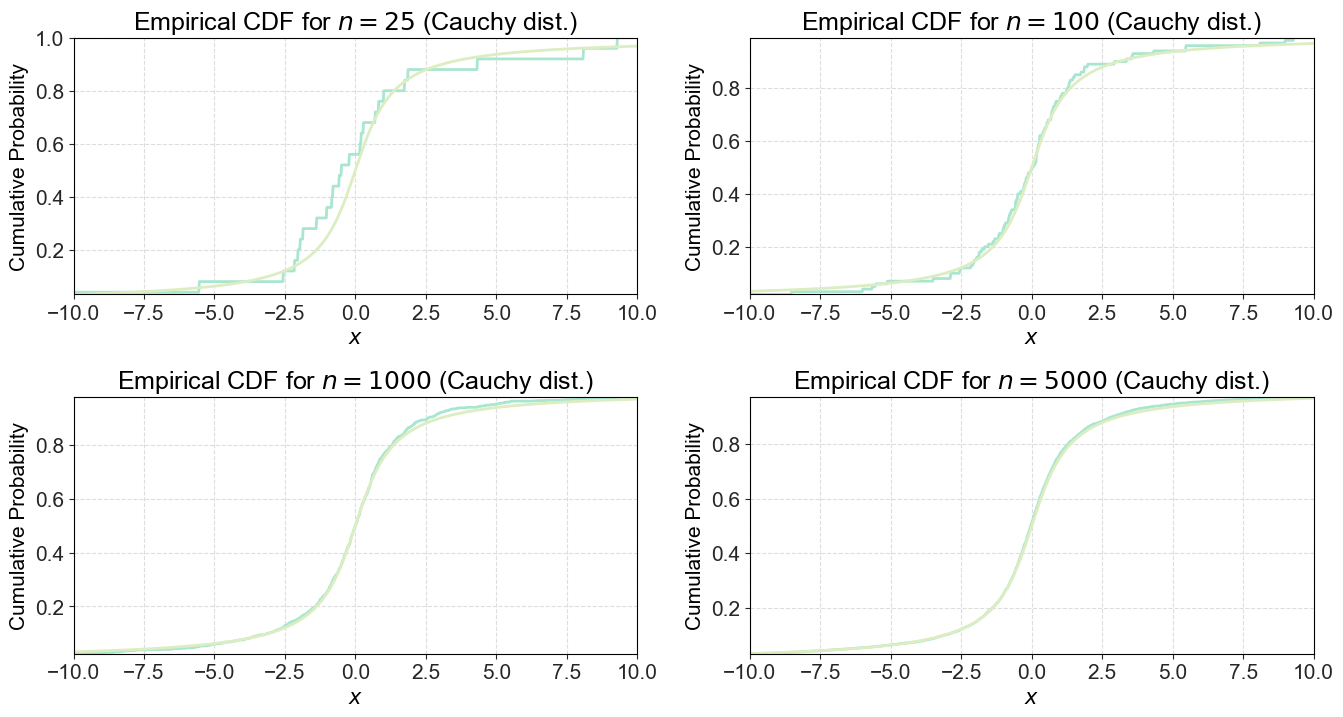

In [46]:
sample_sizes = [25, 100, 1000, 5000]

fig, ax = plt.subplots(2,2, figsize=(16, 8))
ax = ax.flatten()

x = np.linspace(-10.0, 10.0, 1000)

for i in range(4):
    
    sample_size = sample_sizes[i]    
    temp_data = random_data[:sample_size]
    
    ax[i].plot(x, calculate_edf(x, temp_data))
    ax[i].plot(x, stats.cauchy.cdf(x))
    
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('Cumulative Probability')
    ax[i].set_title('Empirical CDF for $n={}$ (Cauchy dist.)'.format(sample_size))

fig.subplots_adjust(hspace=0.4)

__Question 2__

In [47]:
def edf_confidence(edf: np.ndarray, n: int, alpha: float=0.05) -> Tuple[np.ndarray, np.ndarray]:
    
    """
    Calculates the confidence interval for the empirical CDF
    
    Parameter
    ---------
    edf: 
        Values of the EDF for which to find the confidence interval
    n: 
        Number for observations 
    alpha: 
        Confidence level. 
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Lower and upper limit of confidence interval 
    
    """
    
    # epsilon
    epsilon = np.sqrt(np.log(2.0 / alpha) / (2 * n))
    
    # lower and upper bounds 
    lower = np.clip(edf - epsilon, 0.0, 1.0)
    upper = np.clip(edf + epsilon, 0.0, 1.0)
    
    return lower, upper

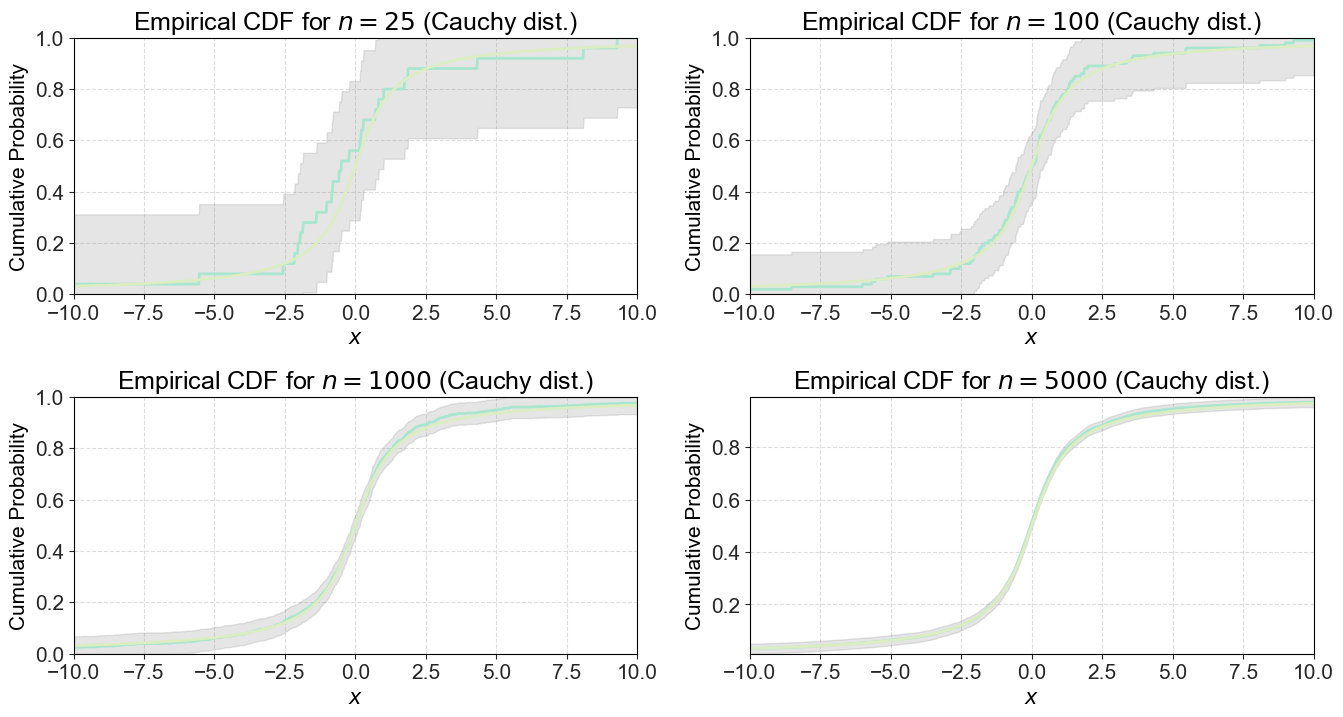

In [48]:
sample_sizes = [25, 100, 1000, 5000]

fig, ax = plt.subplots(2,2, figsize=(16, 8))
ax = ax.flatten()

x = np.linspace(-10.0, 10.0, 1000)
for i in range(4):
    
    sample_size = sample_sizes[i]    
    temp_data = random_data[:sample_size]
    
    edf = calculate_edf(x, temp_data)
    low, up = edf_confidence(edf, sample_size, alpha=0.05)
    
    ax[i].plot(x,edf)
    ax[i].plot(x, stats.cauchy.cdf(x))
    ax[i].fill_between(x, low, up, color='gray', alpha=0.2)
    
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('Cumulative Probability')
    ax[i].set_title('Empirical CDF for $n={}$ (Cauchy dist.)'.format(sample_size))

fig.subplots_adjust(hspace=0.4)

## Problem 3: Moments with scenario probabilities

In this problem, we will look at how we can calculate different moments when we are using scenario probabilities. 

Consider the scenarios and related probabilites: 

In [49]:
x = np.array([0.38874223, 9.64297756, 1.27555492, 3.12537902, 2.4580506,
              0.8053753 , 6.13998831, 7.55690088, 3.97384118, 7.86858951])

print(x)

[0.38874223 9.64297756 1.27555492 3.12537902 2.4580506  0.8053753
 6.13998831 7.55690088 3.97384118 7.86858951]


In [50]:
probs = np.array([0.04650611, 0.06914496, 0.21835384, 0.09998765, 0.02251887,
                  0.00831124, 0.14610489, 0.10819035, 0.07328199, 0.20760009])

print(probs)

[0.04650611 0.06914496 0.21835384 0.09998765 0.02251887 0.00831124
 0.14610489 0.10819035 0.07328199 0.20760009]


__Problem 1__

Use the `numpy.average` function to calculate the mean of the scenarios. Please note that the function has an `weights` argument that can be used to provide scenario specific probabilities. 

__Problem 2__

Define a function which can calculate the variance with scenario probabilities. Calculate the variance. 

Also define a function which calculates the standard devation. Calculate the standard devation. 


__Problem 3__

Consider a second set of scenarios

In [51]:
y = np.array([10.21360159, 13.08162811,  9.33243406,  1.90613543, 17.15583533,
              17.87137586,  1.84765146,  1.8249457 ,  7.36965481,  0.20770526])

print(y)

[10.21360159 13.08162811  9.33243406  1.90613543 17.15583533 17.87137586
  1.84765146  1.8249457   7.36965481  0.20770526]


Define a function which can calculate the covariance between the two variables. Calculate the covariance. 

__Problem 4__

Define a function which can calculate the correlation between the two variables. Calculate the correlation. 


__Problem 5__

Define a function which can calculate the skewness. Calculate the skewness (for $X$). 

__Problem 6__

Define a function which can calculate the kurtosis (excess). Calculate the kurtosis (for $X$). 

### Solution 

__Problem 1__

We can calculate the mean as 

$$
\text{E}[X] =  \sum_{i=1}^n p_i x_i = \boldsymbol{p}^\top \boldsymbol{x}
$$

This can be done directly using `numpy.average`. 

In [52]:
np.average(x, weights=probs)

4.97730699197513

__Problem 2__

In order to define a function calculating the variance, we note that we can write 

$$
\text{Var}[X] = \text{E}[X^2] - \text{E}[X]^2 = \text{E}[(X - \text{E}[X])^2] 
$$

One way of calculating the variance would be 

$$
\text{Var}[X] =  \sum_{i=1}^n p_i (x_i - \text{E}[X])^2
$$

Hence, we can directly apply `numpy.average` inside our function. 

To obtain the standard devation, we simple take the square root. 

In [53]:
def calculate_variance(x: np.ndarray, probs=None, axis=0) -> Union[float, np.ndarray]:

    """
    Calculates variance.

    Parameters
    ----------
    x:
        Data to calculate variance for.
    probs:
        Probabilities.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        Variance.

    """

    m = np.average(x, weights=probs, axis=axis)

    return np.average(np.square(x - m), weights=probs)

In [54]:
def calculate_std(x: np.ndarray, probs: Union[np.ndarray, None] = None, axis=0):

    """
    Calculates standard deviation.

    Parameters
    ----------
    x:
        Data to calculate standard deviation for.
    probs:
        Probabilities.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        Standard devation.

    """

    return np.sqrt(calculate_variance(x, probs, axis))

In [55]:
calculate_variance(x, probs=probs)

8.833624481424264

In [56]:
calculate_std(x, probs=probs)

2.972141396606875

__Problem 3__

We can calculate the covariance using 

$$
\begin{equation*}
\text{Cov}[X,Y]= \text{E}[(X- \text{E}[X])(Y- \text{E}[Y])] = \text{E}[XY] - \text{E}[X]\text{E}[Y]
\end{equation*}
$$

In [57]:
def calculate_covariance(x: np.ndarray, y: np.ndarray, probs: Union[np.ndarray, None] = None, axis=0):

    """
    Calculates covariance between two variables.

    Parameters
    ----------
    x:
        First variable.
    y:
        Second variable.
    probs:
        Probabilities.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        Covariance.

    """

    m_x = np.average(x, weights=probs, axis=axis)
    m_y = np.average(y, weights=probs, axis=axis)

    m_xy = np.average(x*y, weights=probs, axis=axis)

    return m_xy - m_x * m_y

In [58]:
calculate_covariance(x, y, probs=probs)

-7.042613842496788

__Problem 4__


The correlation coefficient is defined as 

$$
\rho_{X,Y} = \text{Corr}[X,Y] = \frac{\text{Cov}[X,Y] }{\sqrt{\text{Var}[X]\text{Var}[Y]}}
$$



In [59]:
def calculate_correlation(x: np.ndarray, y: np.ndarray, probs: Union[np.ndarray, None] = None, axis=0):

    """
    Calculates correlation between two variables.

    Parameters
    ----------
    x:
        First variable.
    y:
        Second variable.
    probs:
        Probabilities.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        Correlation.

    """

    c = calculate_covariance(x, y, probs, axis)
    std_x = calculate_std(x, probs, axis)
    std_y = calculate_std(y, probs, axis)

    return c / (std_x * std_y)

In [60]:
calculate_correlation(x, y, probs=probs)

-0.491688737243142

__Problem 5__


The skewness coefficient

$$
\begin{equation*}
\text{Skew}[X] = \frac{\text{E}[(X-\mu)^3]}{\sigma^3}
\end{equation*}
$$

In [61]:
def calculate_skewness(x: np.ndarray, probs: Union[np.ndarray, None] = None, axis=0):

    """
    Calculates skewness.

    Parameters
    ----------
    x:
        Data to calculate skewness for.
    probs:
        Probabilities.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        skewness.

    """

    m_x = np.average(x, weights=probs, axis=axis)
    m_x_3 = np.average(x ** 3, weights=probs, axis=axis)
    std = calculate_std(x, probs=probs, axis=axis)

    return (m_x_3 - 3 * m_x * std ** 2 - m_x ** 3) / (std ** 3)

In [62]:
calculate_skewness(x, probs=probs)

-0.1186305500914665

__Problem 6__

$$
\begin{equation*}
 \text{Kurt}[X] = \frac{\text{E}[(X-\mu)^4]}{\sigma^4} - 3
\end{equation*}
$$

In [63]:
def calculate_kurtosis(x: np.ndarray, probs: Union[np.ndarray, None] = None, excess: bool = True, axis=0):

    """
    Calculates kurtosis.

    Parameters
    ----------
    x:
        Data to calculate kurtosis for.
    probs:
        Probabilities.
    excess:
        Boolean indicating wether to calculate excess kurtosis. Default is True.
    axis:
        Axis over which to calculate.

    Returns
    -------
    Union[float, np.ndarray]
        Kurtosis.

    """

    x_d = x - np.average(x, weights=probs, axis=axis)
    m_x_d_4 = np.average(x_d ** 4, weights=probs, axis=axis)

    std = calculate_std(x, probs=probs, axis=axis)

    if excess:
        return m_x_d_4 / (std ** 4) - 3.0
    else:
        return m_x_d_4 / (std ** 4)

In [64]:
calculate_kurtosis(x, probs=probs)

-1.4798341657920455

## Problem 4: Exponential decay probabilities 

In this problem, we will see how to implement exponential decay probabilities. 

A typical use case for exponential smoothing is for estimating parameters in a parametric Monte Carlo simulation. One will use an exponential filter to estimate the expected values, $\boldsymbol{\mu}^{\lambda}$,  and covariance matrix, $\boldsymbol{\Sigma}^{\lambda}$, of the risk drivers and assume $\mathbf{X} \sim N(\boldsymbol{\mu}^{\lambda}, \boldsymbol{\Sigma}^{\lambda})$. More specifically, 


$$
\boldsymbol{\mu}^{\lambda} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and 

$$
\boldsymbol{\Sigma}^{\lambda} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda} (\boldsymbol{\mu}^{\lambda})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data. 

However, we will be able to specify the distribution without applying Monte Carlo simulations with a particular distributional assumption. We can simply set $p_t$ equal to the exponential decay factor (we need to account for a scaling factor). 

$$
p_t \propto e^{-\lambda (T-t)}
$$

such that more recent scenarios are more likely (we use $t$ and $T$ instead of $i$ and $n$ because we typically work with exponential smoothing in a time-series context). 

__Note: Half-life__

The half-life, $\kappa$, is equal to 

$$
\kappa = \frac{\ln 2}{\lambda}
$$

To see this, consider the value af time $t$, $N_t$, given the value at time $0$, $N_0$ and exponential decay:

$$
N_t = N_0 e^{-\lambda t}
$$

To see when the value is halved we replace $N_t$ with $N_0 / 2$ and insert $\kappa$ inplace of $t$

$$
\frac{N_0}{2} = N_0 e^{-\lambda \kappa}
$$

Taking the natural logarithm on both sides gives us

$$
\ln N_0 - \ln 2 = \ln N_0 - \lambda \kappa
$$

Solving for $\kappa$ yields

$$
\kappa = \frac{\ln 2}{\lambda}
$$

This also means that we can write 

$$
p_t \propto e^{-\frac{\ln 2}{\kappa} (T-t)}
$$


__Question 1__

Implement a function that can calculate exponential decay probabilities for a given time point in a sample, say `target_time_point`, an array of time-points, say `time_points`, and a half-life parameter, say `half_life`. 

Call the function with 

```
target_time_point = 1000
time_points = np.linspace(0, 1000, 1001)
half_life = 100
```

Plot the resulting probabilities. 

__Question 2__

Obtain log-returns from the S&P 500 since 2010-01-01 (hint: use `pandas-datareader`, ticker: '^GSPC', data_source: 'yahoo'). 

Calculate exponential decay probabilites with a half-life of 50, 100 and 500 business days (assuming equally spaced observations).

Plot the probabilities. 

Calculate the standard deviation for the two sets of scenario probabilities. 



### Solution 

__Question 1__

In [65]:
def calculate_exponential_decay_probabilities(target_time_point: Union[int, float], time_points: np.ndarray,
                                              half_life: Union[float, int]) -> np.ndarray:

    """
    Calculates exponential decay probabilities for an array of time points based on a target timepoint and a half life.

    Parameters
    ----------
    target_time_point:
        The target time point.
    time points:
        The array of time points to calculate probabilities for.
    half_life:
        The half life of the exponential decay.

    Returns
    -------
    Exponential decay probabilities.

    """

    numerator = np.exp(-np.log(2) / half_life * 
                       np.clip(target_time_point - time_points, 0, np.inf))
    denominator = np.sum(numerator)

    p_t = numerator / denominator

    return p_t

In [66]:
target_time_point = 1000
time_points = np.linspace(0, 1000, 1001)
half_life = 100

probs = calculate_exponential_decay_probabilities(target_time_point=target_time_point,
                                                  time_points=time_points, half_life=half_life)

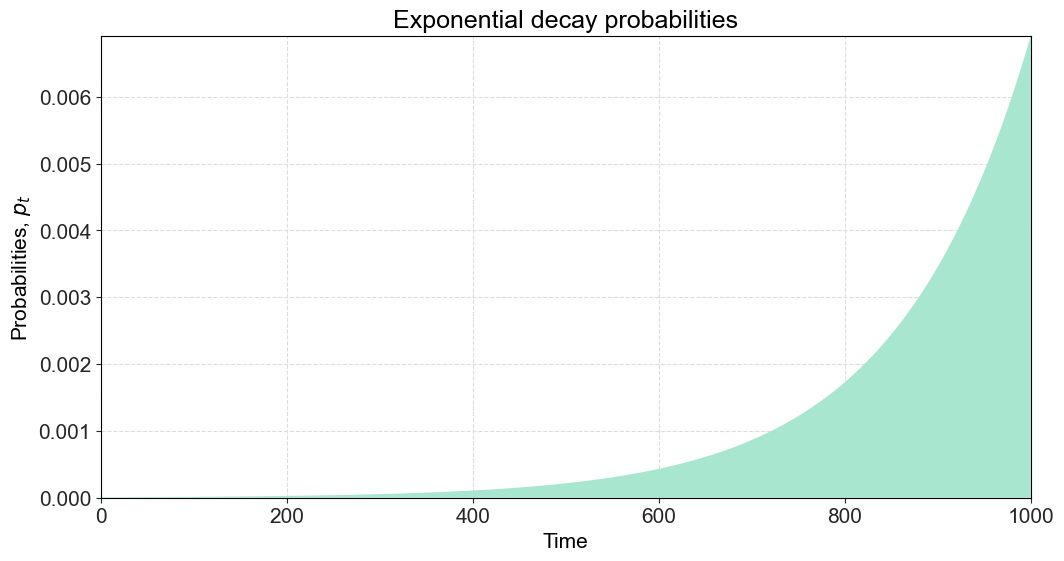

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(time_points, probs)
ax.set_xlabel('Time')
ax.set_ylabel('Probabilities, $p_t$')
ax.set_title('Exponential decay probabilities');

__Question 2__

In [68]:
"""
Get data
"""
df_index = wb.get_data_yahoo('^GSPC', start=datetime.date(2010, 1, 1))['Adj Close']

df_log_returns = np.log(df_index / df_index.shift(1)).dropna()

[*********************100%%**********************]  1 of 1 completed


In [69]:
"""
Calculate probabilities
"""

log_returns = df_log_returns.values
last_time_point = len(log_returns)
time_points = np.arange(1, last_time_point + 1, 1)

probs_50 = calculate_exponential_decay_probabilities(target_time_point=last_time_point, time_points=time_points, half_life=50)
probs_100 = calculate_exponential_decay_probabilities(target_time_point=last_time_point, time_points=time_points, half_life=100)
probs_500 = calculate_exponential_decay_probabilities(target_time_point=last_time_point, time_points=time_points, half_life=500)

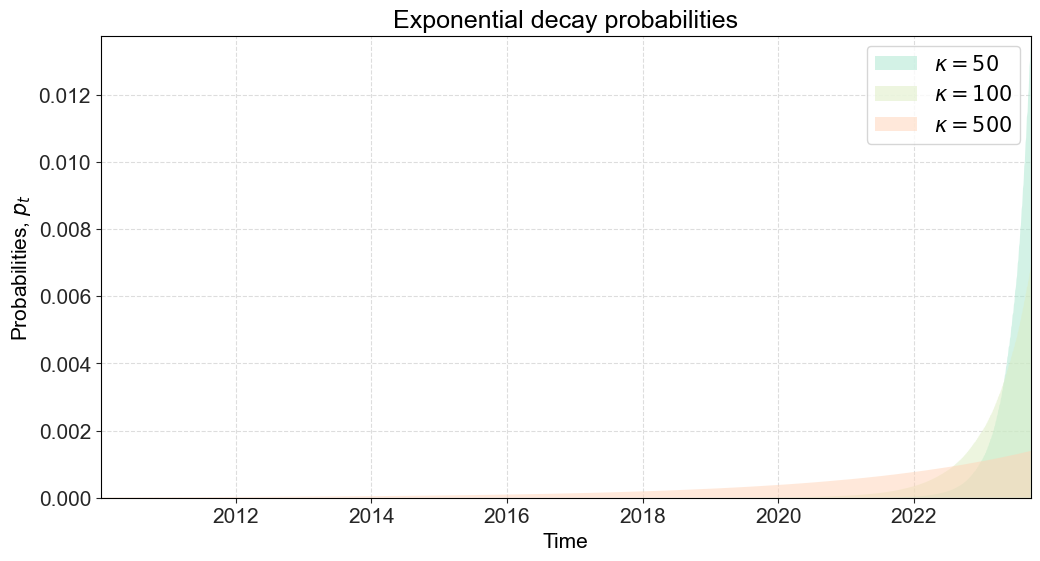

In [70]:
"""
Plot probabilities
"""

idx_vals = df_log_returns.index 

fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(idx_vals, probs_50, alpha=0.5, label="$\\kappa = 50$")
ax.fill_between(idx_vals, probs_100, alpha=0.5, label="$\\kappa = 100$")
ax.fill_between(idx_vals, probs_500, alpha=0.5, label="$\\kappa = 500$")
ax.set_xlabel('Time')
ax.set_ylabel('Probabilities, $p_t$')
ax.legend()
ax.set_title('Exponential decay probabilities');

In [71]:
"""
Ann. volatility in %, half-life of 50 days
"""

calculate_std(log_returns, probs_50) * 100 * np.sqrt(250)

13.342584241888572

In [72]:
"""
Ann. volatility in %, half-life of 100 days
"""

calculate_std(log_returns, probs_100) * 100 * np.sqrt(250)

16.187714272180095

In [73]:
"""
Ann. volatility in %, half-life of 500 days
"""

calculate_std(log_returns, probs_500) * 100 * np.sqrt(250)

19.405120847916862

# References

## Articles

[Attilio Meucci (2010), Historical Scenarios with Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1696802)


## Books

